<a href="https://colab.research.google.com/github/kostique23/Quick-Draw-Image-Classifier-with-FastAPI/blob/main/quickdraw_classifier_fastapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Модель взята из моего прошлого проекта. Ее можно НЕ ЗАПУСКАТЬ! Я ее сохранил, выгрузил на диск и скачиваю для выполнения данного проекта с облака. Оставил структуру обучения модели чисто для ознакомления, как она была получена

Набор данных Quick Draw представляет собой коллекцию из 50 миллионов рисунков в 345 категориях, созданных участниками игры "Quick, Draw!".
Чтобы облегчить задачу и обучение я создал текстовый файл с списком из сотни рандомных классов по Quick, Draw!

In [ ]:
#@title Импорт библиотек

import urllib.request
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import time

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
#@title Загрузка классов

url = "https://storage.yandexcloud.net/homework/mini_classes.txt"
urllib.request.urlretrieve(url, "mini_classes.txt")

with open("mini_classes.txt", "r") as f:
    classes = f.readlines()

classes = [c.strip().replace(' ', '_') for c in classes]
os.makedirs("data", exist_ok=True)

def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [ ]:
#@title Загрузка данных

def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]


    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

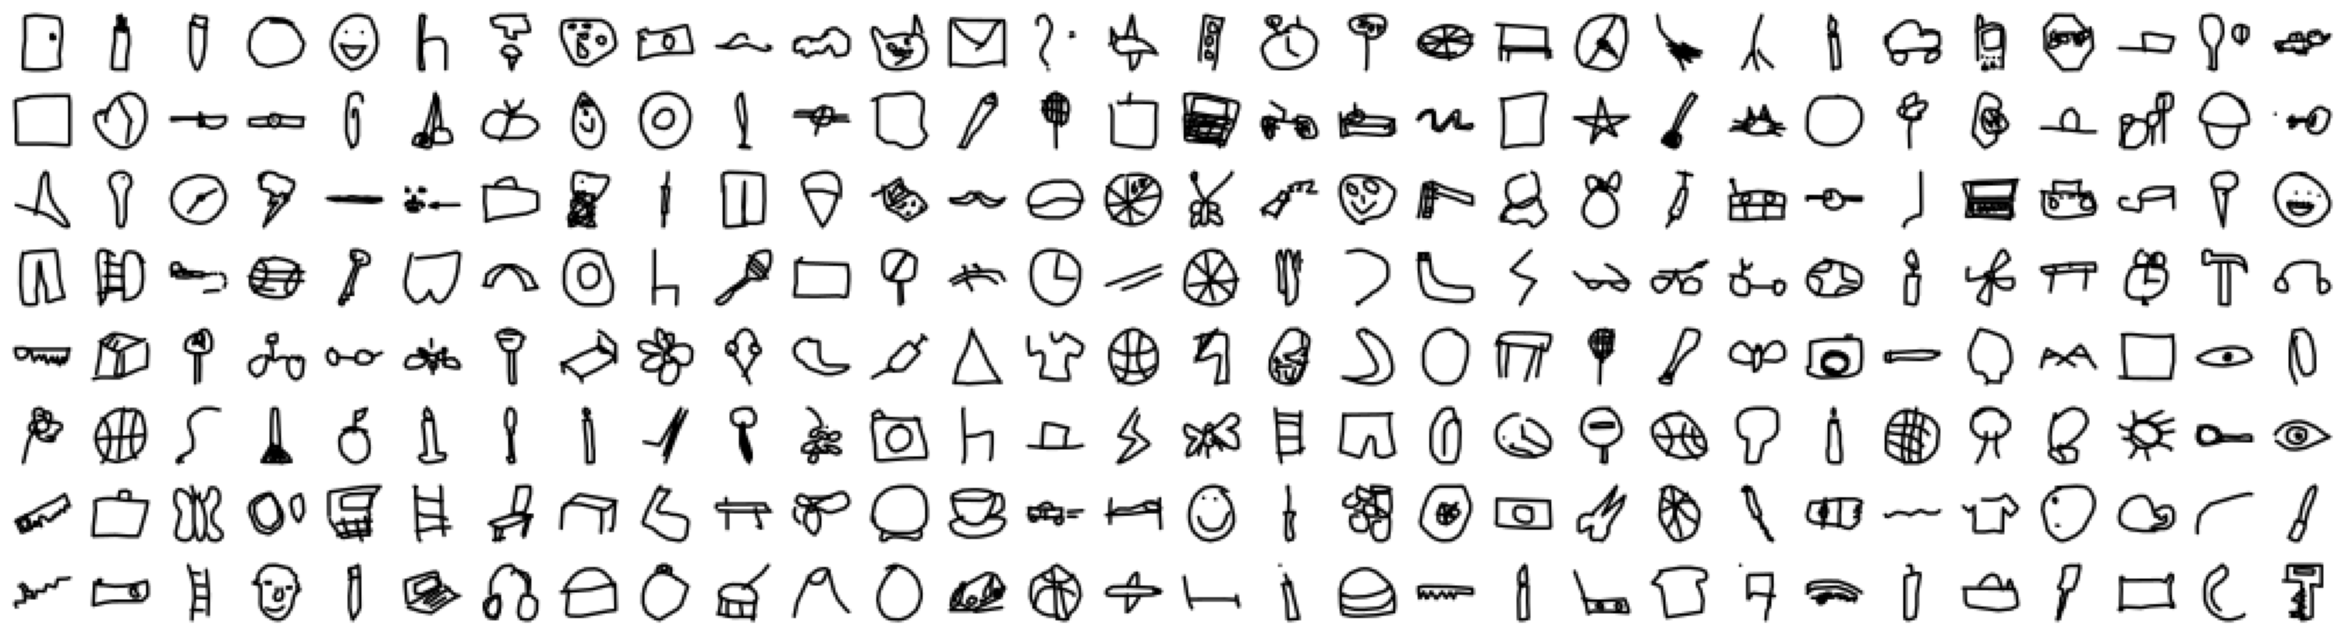

In [ ]:
#@title Визуализация данных

num_images_to_visualize = 240
selected_indices = np.random.choice(len(x_train), num_images_to_visualize, replace=False)
subset_images = x_train[selected_indices]

plt.figure(figsize=(30, 8))
for i in range(num_images_to_visualize):
    plt.subplot(8, 30, 1 + i)
    plt.axis('off')
    plt.imshow(subset_images[i].reshape((28, 28)), cmap='gray_r')

In [ ]:
#@title Предобработка данных для обучения

x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#@title Архитектура модели

model = keras.Sequential()
model.add(layers.Convolution2D(32, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))  # Добавлен Dropout для предотвращения переобучения
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))  # Добавлен Dropout для предотвращения переобучения
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Увеличено число нейронов в Dense-слое
model.add(layers.Dropout(0.5))  # Добавлен Dropout для предотвращения переобучения
model.add(layers.Dense(num_classes, activation='softmax'))

adam = keras.optimizers.Adam(lr=0.0001)  # Изменена скорость обучения
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])

In [ ]:
#@title Обучение модели

start = time.time()
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=15)
end = time.time()

elapsed_time = end - start
minutes = int(elapsed_time // 60)
second = int(elapsed_time % 60)

model.save('Quick_Draw_model.h5')

Epoch 1/15
1125/1125 - 18s - loss: 2.3007 - top_k_categorical_accuracy: 0.7078 - val_loss: 1.3138 - val_top_k_categorical_accuracy: 0.8847 - 18s/epoch - 16ms/step
Epoch 2/15
1125/1125 - 11s - loss: 1.5311 - top_k_categorical_accuracy: 0.8564 - val_loss: 1.0988 - val_top_k_categorical_accuracy: 0.9081 - 11s/epoch - 10ms/step
Epoch 3/15
1125/1125 - 11s - loss: 1.3509 - top_k_categorical_accuracy: 0.8799 - val_loss: 0.9963 - val_top_k_categorical_accuracy: 0.9179 - 11s/epoch - 10ms/step
Epoch 4/15
1125/1125 - 12s - loss: 1.2529 - top_k_categorical_accuracy: 0.8918 - val_loss: 0.9434 - val_top_k_categorical_accuracy: 0.9228 - 12s/epoch - 10ms/step
Epoch 5/15
1125/1125 - 11s - loss: 1.1830 - top_k_categorical_accuracy: 0.8998 - val_loss: 0.9005 - val_top_k_categorical_accuracy: 0.9270 - 11s/epoch - 9ms/step
Epoch 6/15
1125/1125 - 11s - loss: 1.1350 - top_k_categorical_accuracy: 0.9046 - val_loss: 0.8654 - val_top_k_categorical_accuracy: 0.9309 - 11s/epoch - 9ms/step
Epoch 7/15
1125/1125 - 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#@title Оценка точности модели

score = model.evaluate(x_test, y_test, verbose=0)
print(f"Время выполнения обучения модели: {minutes} минут {second} секунд")
print(f"Точность на тестовой выборке: {int(score[1] * 100)}%")

Время выполнения обучения модели: 3 минут 25 секунд
Точность на тестовой выборке: 93%


1/1 [==============================] - 0s 277ms/step


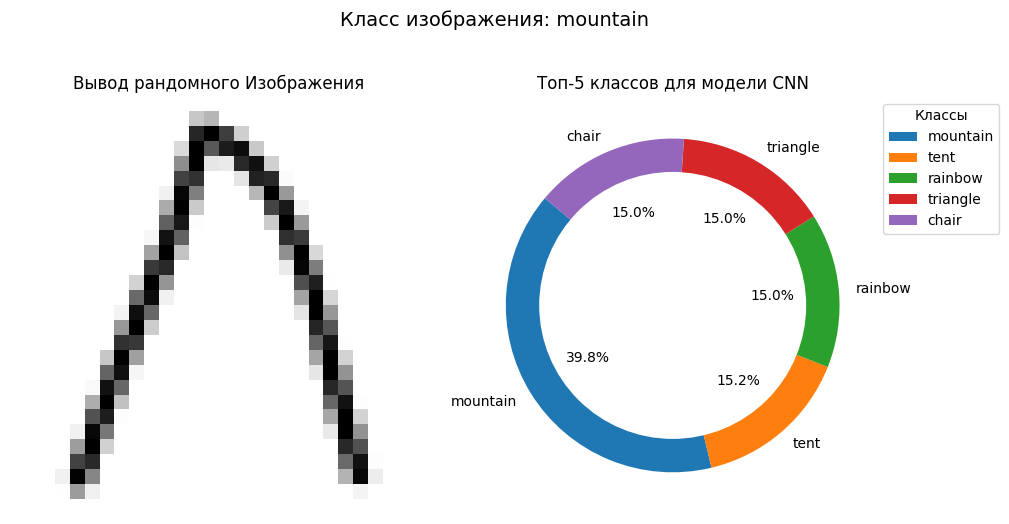

In [ ]:
#@title Вывод предсказаний

# Выбор рандомного изображения
idx = randint(0, len(x_test))
img = x_test[idx]

# Создание сетки для изображения и графика
plt.figure(figsize=(10, 5))

# Первый подграфик - изображение
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray_r')
plt.title('Вывод рандомного Изображения')
plt.axis('off')

# Второй подграфик - диаграмма
plt.subplot(1, 2, 2)
pred = model.predict(np.expand_dims(img, axis=0))[0]
softmax_pred = np.exp(pred) / np.sum(np.exp(pred))
ind = (-softmax_pred).argsort()[:5]

labels = [class_names[i] for i in ind]
sizes = [softmax_pred[i] * 100 for i in ind]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
centre_circle = plt.Circle((0, 0), 0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Топ-5 классов для модели CNN')
plt.legend(labels, title="Классы", loc="upper right", bbox_to_anchor=(1.3, 1))

# Добавление заголовка класса для выпадающего изображения
class_idx = np.argmax(y_test[idx])
class_name = class_names[class_idx]
plt.suptitle(f'Класс изображения: {class_name}', y=1.05, fontsize=14)

# Вывод графиков
plt.tight_layout()
plt.show()

### Реализация REST API с помощью FastAPI

In [ ]:
#@title Установка библиотеки FastAPI и вспомогательных компонентов

!pip install fastapi
!pip install uvicorn
!pip install python-multipart
!pip install pyngrok
!pip install requests
!pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 495.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Импорт библиотек

from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse, HTMLResponse
from PIL import Image
import numpy as np
import tensorflow as tf
import nest_asyncio
import io
from PIL import Image
import uvicorn
from pyngrok import ngrok
import requests
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

nest_asyncio.apply()

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
#@title Загрузка модели и классов

model_url = 'https://storage.yandexcloud.net/homework/Quick_Draw_model.h5'
local_model_path = 'Quick_Draw_model.h5'

response = requests.get(model_url)
with open(local_model_path, 'wb') as f:
    f.write(response.content)


url = 'https://storage.yandexcloud.net/homework/mini_classes.txt'
response = requests.get(url)
class_names = response.text.splitlines()

In [ ]:
#@title Предобработка изображения

app = FastAPI()

def preprocess_image(image_bytes):
    try:
        image = Image.open(io.BytesIO(image_bytes)).convert('L')
        image = image.resize((28, 28))
        image_array = np.array(image)
        image_array = image_array / 255.0
        image_array = image_array.reshape(1, 28, 28, 1).astype('float32')
        debug_image = Image.fromarray((image_array.squeeze() * 255).astype(np.uint8))
        debug_image.save("preprocessed_image_debug.png")
        return image_array
    except Exception as e:
        print(f"Ошибка предобработки изображения: {e}")
        return None

In [ ]:
#@title Эндпойнт для классификации

@app.post("/classify")
async def classify(file: UploadFile = File(...)):
    try:
        model = tf.keras.models.load_model(local_model_path)

        image_bytes = await file.read()
        with open("input_image.png", "wb") as f:
            f.write(image_bytes)

        input_image = Image.open("input_image.png")
        input_image.show()

        image = preprocess_image(image_bytes)
        logger.info(f"Предобработанное изображение: {image}")

        if image is None:
            raise HTTPException(status_code=500, detail="Ошибка предобработки изображения")

        prediction = model.predict(image)
        top_5_indices = np.argsort(prediction[0])[-5:][::-1]
        top_5_classes = [class_names[i] for i in top_5_indices]
        top_5_probabilities = [prediction[0][i] * 100 for i in top_5_indices]

        total_prob = sum(top_5_probabilities)
        normalized_probabilities = [(prob / total_prob) * 100 for prob in top_5_probabilities]
        formatted_probabilities_all_classes = [f"{prob:.1f}%" for prob in top_5_probabilities]
        formatted_probabilities = [f"{prob:.1f}%" for prob in normalized_probabilities]

        print(f"Предсказанные классы: {top_5_classes}")
        print(f"Процент схожести среди 100 классов: {formatted_probabilities_all_classes}")
        print(f"Процентное соотношение среди 5-ти предсказанных классов: {formatted_probabilities}")

        result = {
            "top_5_classes": top_5_classes,
            "top_5_probabilities": top_5_probabilities
        }

        response = JSONResponse(result)

        response.headers["Cache-Control"] = "no-cache, no-store, must-revalidate"
        response.headers["Pragma"] = "no-cache"
        response.headers["Expires"] = "0"

        return response

    except Exception as e:
        print(f"Ошибка классификации: {e}")
        return JSONResponse({"error": str(e)}, status_code=500)

In [ ]:
#@title HTML-контент для страницы рисования и классификации

drawing_html_content = """
<!DOCTYPE html>
<html lang="ru">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Нарисуй свой рисунок в этом окне</title>
    <style>
        body {
            background-color: #FFD139;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
            font-family: Arial, sans-serif;
        }
        #container {
            display: flex;
            flex-direction: column;
            align-items: center;
            gap: 20px;
            padding: 20px;
            background-color: white;
            border-radius: 8px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        }
        #drawing-area {
            width: 280px;
            height: 280px;
            border: 2px solid black;
        }
        #drawing-area canvas {
            width: 100%;
            height: 100%;
            background-color: white;
        }
        #result {
            width: 100%;
            max-width: 600px;
            padding: 20px;
            background-color: #f9f9f9;
            border: 1px solid #ccc;
            border-radius: 8px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            display: flex;
            flex-direction: column;
            align-items: center;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 10px;
        }
        th, td {
            padding: 12px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }
        th {
            background-color: #f2f2f2;
        }
        .button-container {
            display: flex;
            gap: 20px;
        }
        button {
            font-size: 18px;
            padding: 12px 24px;
            background-color: #2FAA50;
            color: white;
            border: none;
            border-radius: 8px;
            cursor: pointer;
            transition: background-color 0.3s ease, box-shadow 0.3s ease;
            box-shadow: 4px 4px 8px rgba(0, 0, 0, 0.2);
        }
        button:hover {
            background-color: #249642;
            box-shadow: 6px 6px 10px rgba(0, 0, 0, 0.4);
        }
        #chart-container {
            width: 80%;
            max-width: 300px;
            display: flex;
            justify-content: center;
        }
        #prediction-message {
            margin-top: 20px;
            font-weight: bold;
        }
    </style>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
</head>
<body>
    <div id="container">
        <h1>Нарисуй свой рисунок в этом окне</h1>
        <div id="drawing-area">
            <canvas id="canvas" width="280" height="280"></canvas>
        </div>
        <div class="button-container">
            <button onclick="predictDrawing()">Классифицировать</button>
            <button onclick="resetDrawing()">Начать заново</button>
        </div>
        <div id="result">
            <div id="chart-container">
                <canvas id="chart" width="180" height="180"></canvas>
            </div>
            <div id="table-container">
                <table id="prediction-table">
                    <thead>
                        <tr>
                            <th>Класс</th>
                            <th>Вероятность (%)</th>
                        </tr>
                    </thead>
                    <tbody id="prediction-body">
                    </tbody>
                </table>
            </div>
            <div id="prediction-message"></div>
        </div>
    </div>

    <script>
        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        let isDrawing = false;
        let lastX;
        let lastY;

        canvas.addEventListener('mousedown', startDrawing);
        canvas.addEventListener('mousemove', draw);
        canvas.addEventListener('mouseup', stopDrawing);
        canvas.addEventListener('mouseout', stopDrawing);

        function startDrawing(e) {
            isDrawing = true;
            lastX = e.offsetX;
            lastY = e.offsetY;
            ctx.beginPath();
            ctx.moveTo(lastX, lastY);
        }

        function draw(e) {
            if (!isDrawing) return;

            ctx.strokeStyle = ' black';
            ctx.lineWidth = 10;
            ctx.lineCap = 'round';

            const rect = canvas.getBoundingClientRect();
            const x = e.clientX - rect.left;
            const y = e.clientY - rect.top;

            ctx.lineTo(x, y);
            ctx.stroke();

            lastX = x;
            lastY = y;
        }

        function stopDrawing() {
            isDrawing = false;
        }

        function isCanvasBlank(canvas) {
            const context = canvas.getContext('2d');
            const pixelBuffer = new Uint32Array(
                context.getImageData(0, 0, canvas.width, canvas.height).data.buffer
            );
            return pixelBuffer.every(color => color === 0xFFFFFFFF);
        }

        async function predictDrawing() {
            if (isCanvasBlank(canvas)) {
                alert('Пожалуйста, нарисуйте что-нибудь перед классификацией.');
                return;
            }

            const dataURL = canvas.toDataURL('image/png');
            console.log(dataURL);

            const blob = await fetch(dataURL).then(res => res.blob());
            console.log(blob);

            const file = new File([blob], 'drawing.png', { type: 'image/png' });

            const formData = new FormData();
            formData.append('file', file);

            fetch('/classify', {
                method: 'POST',
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                updateChart(data.top_5_classes, data.top_5_probabilities);
                updateTable(data.top_5_classes, data.top_5_probabilities);
                updatePredictionMessage(data.top_5_classes[0]);
            })
            .catch(error => {
                console.error(error);
                alert('Ошибка предсказания');
            });
        }

        function updateChart(labels, data) {
            const ctx = document.getElementById('chart').getContext('2d');
            if (window.myChart) {
                window.myChart.destroy();
            }
            window.myChart = new Chart(ctx, {
                type: 'pie',
                data: {
                    labels: labels,
                    datasets: [{
                        data: data,
                        backgroundColor: ['red', 'blue', 'green', 'yellow', 'purple'],
                    }]
                },
                options: {
                    responsive: true,
                    plugins: {
                        legend: {
                            position: 'top',
                        },
                        tooltip: {
                            callbacks: {
                                label: function(context) {
                                    return `${context.label}: ${context.raw.toFixed(2)}%`;
                                }
                            }
                        }
                    }
                }
            });
        }

        function updateTable(labels, data) {
            const tableBody = document.getElementById('prediction-body');
            tableBody.innerHTML = '';
            for (let i = 0; i < labels.length; i++) {
                const row = tableBody.insertRow();
                const cell1 = row.insertCell();
                const cell2 = row.insertCell();
                cell1.textContent = labels[i];
                cell2.textContent = data[i].toFixed(2) + '%';
            }
        }

        function updatePredictionMessage(classLabel) {
            const messageDiv = document.getElementById('prediction-message');
            messageDiv.textContent = `Твой рисунок наиболее похож на: ${classLabel}`;
        }

        function resetDrawing() {
            ctx.clearRect(0, 0, canvas.width, canvas.height);
            ctx.fillStyle = 'white';
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            if (window.myChart) {
                window.myChart.destroy();
            }
            const tableBody = document.getElementById('prediction-body');
            tableBody.innerHTML = '';
            const messageDiv = document.getElementById('prediction-message');
            messageDiv.textContent = '';
        }
    </script>
</body>
</html>
"""

In [ ]:
#@title Эндпоинт для страницы рисования и классификации

@app.get("/draw")
async def draw():
    return HTMLResponse(content=drawing_html_content)

In [ ]:
#@title HTML-контент для главной страницы

main_html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Quick Draw Classifier</title>
    <style>
        body {
            background-image: url('https://storage.yandexcloud.net/homework/%D0%9D%D0%B0%D1%87%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F%20%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0.png');
            background-size: cover;
            height: 100vh;
            display: flex;
            justify-content: center;
            align-items: flex-end;
        }
        .start-button {
            font-size: 24px;
            padding: 16px 32px;
            margin-bottom: 50px;
            background-color: #FFD139;
            border: none;
            border-radius: 8px;
            box-shadow: 8px 8px 16px rgba(0, 0, 0, 0.5);
            transition: box-shadow 0.3s ease-in-out;
        }
        .start-button:hover {
            box-shadow: 12px 12px 24px rgba(0, 0, 0, 0.7);
        }
    </style>
</head>
<body>
    <button class="start-button" onclick="window.location.href='/draw'">Начать</button>
</body>
</html>
"""

In [ ]:
#@title Эндпоинт для главной страницы

@app.get("/")
async def main():
    return HTMLResponse(content=main_html_content)

In [ ]:
#@title Запуск сервера

def run_with_ngrok(app):
    ngrok_auth_token = "2iIN4KRs8A2dFRZ61N93Qr0SG4D_4A7BeVv8XWXj8KJoT9zn1"
    ngrok.set_auth_token(ngrok_auth_token)
    ngrok_tunnel = ngrok.connect(8000)
    print('Public URL:', ngrok_tunnel.public_url)

    uvicorn.run(app, host="127.0.0.1", port=8000)

if __name__ == "__main__":
    run_with_ngrok(app)

Public URL: https://b823-34-171-205-115.ngrok-free.app


INFO:     Started server process [535]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     77.91.127.205:0 - "GET / HTTP/1.1" 200 OK
INFO:     77.91.127.205:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     77.91.127.205:0 - "GET /draw HTTP/1.1" 200 OK
1/1 [==============================] - 0s 102ms/step
Предсказанные классы: ['basketball', 'screwdriver', 'bed', 'umbrella', 'baseball']
Процент схожести среди 100 классов: ['10.7%', '8.9%', '7.8%', '6.7%', '4.4%']
Процентное соотношение среди 5-ти предсказанных классов: ['27.7%', '23.0%', '20.3%', '17.5%', '11.5%']
INFO:     77.91.127.205:0 - "POST /classify HTTP/1.1" 200 OK
1/1 [==============================] - 0s 109ms/step
Предсказанные классы: ['scissors', 'bridge', 'tree', 'broom', 'key']
Процент схожести среди 100 классов: ['5.3%', '4.8%', '4.2%', '4.2%', '2.5%']
Процентное соотношение среди 5-ти предсказанных классов: ['25.2%', '22.9%', '20.3%', '19.8%', '11.9%']
INFO:     77.91.127.205:0 - "POST /classify HTTP/1.1" 200 OK
1/1 [==============================] - 0s 104ms/step
Предсказанные классы: ['tree

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [535]


KeyboardInterrupt: 

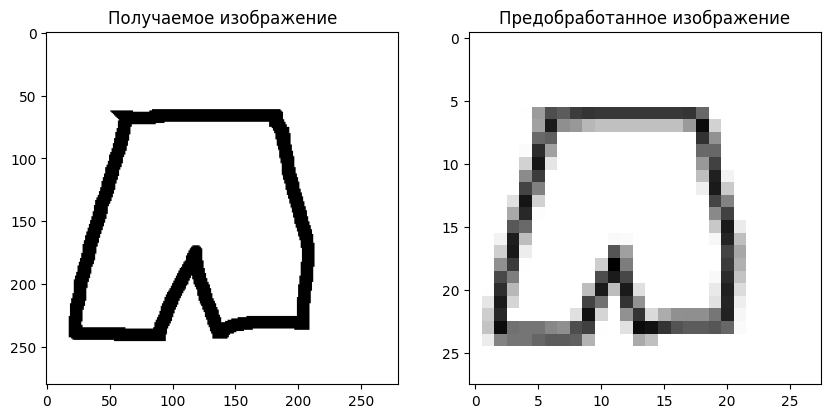

In [ ]:
#@title  Отображение последнего получаемого рисунка и его предобработанная версия для предсказаний

input_image_path = "/content/input_image.png"
preprocessed_image_path = "/content/preprocessed_image_debug.png"

input_image = Image.open(input_image_path)
preprocessed_image = Image.open(preprocessed_image_path)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Получаемое изображение")
plt.imshow(input_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Предобработанное изображение")
plt.imshow(preprocessed_image, cmap="gray")

plt.show()

1/1 [==============================] - 0s 110ms/step


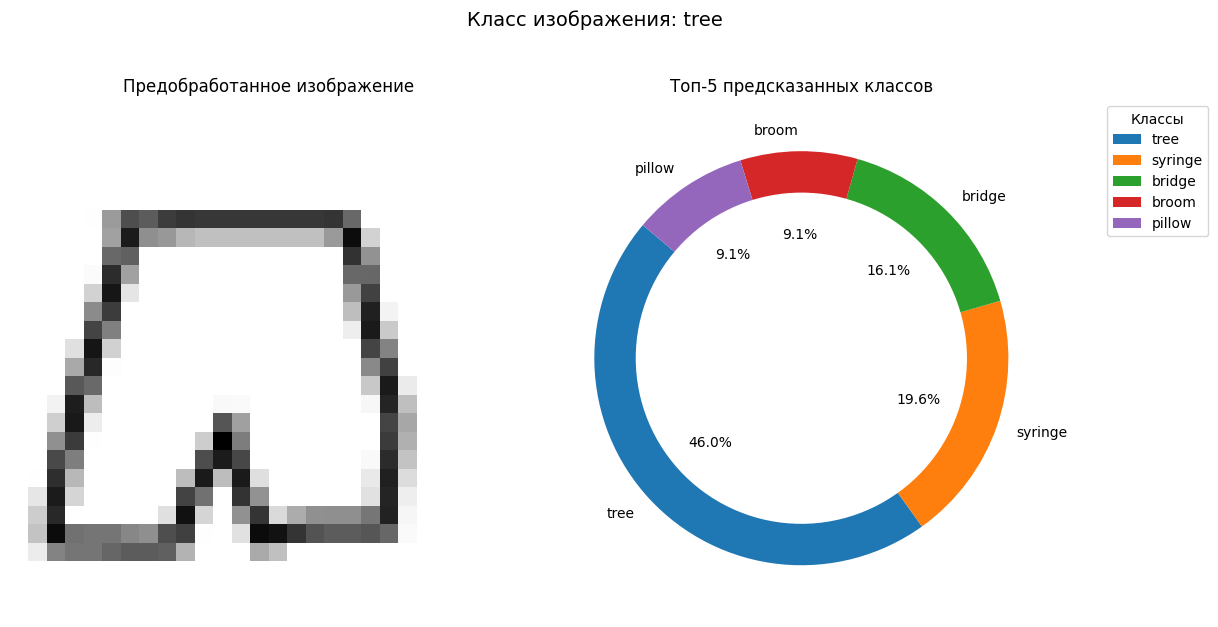

Процентное соотношение предсказаний:
+---+----------------------+----------------------------+----------------------------------------------+
|   | Предсказанные классы | Схожесть среди 100 классов | Соотношение среди 5-ти предсказанных классов |
+---+----------------------+----------------------------+----------------------------------------------+
| 0 |         tree         |           21.4%            |                    46.0%                     |
| 1 |       syringe        |            9.1%            |                    19.6%                     |
| 2 |        bridge        |            7.5%            |                    16.1%                     |
| 3 |        broom         |            4.2%            |                     9.1%                     |
| 4 |        pillow        |            4.2%            |                     9.1%                     |
+---+----------------------+----------------------------+----------------------------------------------+


In [ ]:
#@title Проверка отработки предсказания внутри блокнота по последнему отрисованному и предобработанному изображению с веб-страницы

import pandas as pd


model_url = 'https://storage.yandexcloud.net/homework/Quick_Draw_model.h5'
local_model_path = 'Quick_Draw_model.h5'

response = requests.get(model_url)
with open(local_model_path, 'wb') as f:
    f.write(response.content)

url = 'https://storage.yandexcloud.net/homework/mini_classes.txt'
response = requests.get(url)
class_names = response.text.splitlines()

preprocessed_image_path = "/content/preprocessed_image_debug.png"
preprocessed_image = Image.open(preprocessed_image_path)
preprocessed_image_array = np.array(preprocessed_image)
preprocessed_image_array = preprocessed_image_array.reshape(1, 28, 28, 1).astype('float32')
preprocessed_image_array /= 255.0

model = tf.keras.models.load_model(local_model_path)

def plot_prediction(image_array, class_names, model):
    prediction = model.predict(image_array)
    top_5_indices = np.argsort(prediction[0])[-5:][::-1]
    top_5_classes = [class_names[i] for i in top_5_indices]
    top_5_probabilities = [prediction[0][i] * 100 for i in top_5_indices]


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_array.squeeze(), cmap='gray')
    plt.title('Предобработанное изображение')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.pie(top_5_probabilities, labels=top_5_classes, autopct='%1.1f%%', startangle=140)
    centre_circle = plt.Circle((0, 0), 0.80, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Топ-5 предсказанных классов')
    plt.legend(title="Классы", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.suptitle(f'Класс изображения: {top_5_classes[0]}', y=1.05, fontsize=14)


    plt.tight_layout()
    plt.show()

    total_prob = sum(top_5_probabilities)
    normalized_probabilities = [(prob / total_prob) * 100 for prob in top_5_probabilities]
    formatted_probabilities_all_classes = [f"{prob:.1f}%" for prob in top_5_probabilities]
    formatted_probabilities = [f"{prob:.1f}%" for prob in normalized_probabilities]

    print("Процентное соотношение предсказаний:")
    data = {
        'Предсказанные классы': top_5_classes,
        'Схожесть среди 100 классов': formatted_probabilities_all_classes,
        'Соотношение среди 5-ти предсказанных классов': formatted_probabilities
    }
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

plot_prediction(preprocessed_image_array, class_names, model)